# ROB317 TP2 : Fondamentale
_Auteurs :_
* _Cécile Tillerot_
* _Benjamin Ternot_

## 1. Importation des librairies & fonctions utiles

In [1]:
import cv2
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = True

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [3]:
# Liste des paires d'images à traiter
images_pair_list = [
    ('POP01.jpg', 'POP02.jpg'),
    ('Corridor/bt.001.pgm', 'Corridor/bt.002.pgm'),
    ('Merton1/002.jpg', 'Merton1/003.jpg'),
    ('MOVI_ToyHouse1/im002_1.png', 'MOVI_ToyHouse1/im003_1.png'),
]


## 2. Paramètres importants

### Observer, pour plusieurs paires d’image, les lignes épipolaires calculées ainsi que les résultats intermédiaires (points détectés, appariements sélectionnés).

In [4]:
class EpipolarGeometry:
    """
    Classe pour gérer la géométrie épipolaire entre deux images.
    """

    def __init__(self, img_folder: str):
        """
        Initialise les attributs de la classe.

        Paramètres:
        -----------
        img_folder : str
            Chemin vers le dossier contenant les images.
        """
        self.img_folder = img_folder
        self.results = {}

        self.img1 = None
        self.img2 = None
        self.kp1 = None
        self.kp2 = None
        self.des1 = None
        self.des2 = None
        self.pts1 = None
        self.pts2 = None
        self.FRansac = None
        self.mask = None
        self.inlierpts1 = None
        self.inlierpts2 = None
        self.show_intermediate_results = True

    def reset(self) -> None:
        """
        Réinitialise les attributs de la classe.
        """
        self.img1 = None
        self.img2 = None
        self.kp1 = None
        self.kp2 = None
        self.des1 = None
        self.des2 = None
        self.pts1 = None
        self.pts2 = None
        self.FRansac = None
        self.mask = None
        self.inlierpts1 = None
        self.inlierpts2 = None

    def read_image(self, img_path: str) -> np.ndarray:
        """
        Lit une image depuis le chemin spécifié et la convertit en niveaux de gris.

        Paramètres:
        -----------
        img_path : str
            Chemin vers l'image à lire.

        Retourne:
        ---------
        img : np.ndarray
            Image en niveaux de gris.
        """
        input = cv2.imread(f'{self.img_folder}/{img_path}')
        img = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)
        return img

    def detect_keypoints_and_descriptors(self) -> None:
        """
        Détecte les points clés et calcule les descripteurs en utilisant KAZE.
        """
        kaze = cv2.KAZE_create(upright=False, threshold=0.001, nOctaves=4, nOctaveLayers=4, diffusivity=2)
        self.kp1, self.des1 = kaze.detectAndCompute(self.img1, None)
        self.kp2, self.des2 = kaze.detectAndCompute(self.img2, None)
        imgd = cv2.drawKeypoints(self.img1, self.kp1, None, -1, flags=4)
        if self.show_intermediate_results:
            print(f'Nb de points KAZE : {len(self.kp1)} (gauche) {len(self.kp2)} (droite)')
            plt.imshow(imgd), plt.title(f'{len(self.kp1)} Points KAZE (Image de gauche)')
            plt.show()

    def match_keypoints(self) -> None:
        """
        Apparier les points clés entre les deux images en utilisant le test de ratio de Lowe.
        """
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = bf.knnMatch(self.des1, self.des2, k=2)
        self.pts1 = []
        self.pts2 = []
        good = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                self.pts2.append(self.kp2[m.trainIdx].pt)
                self.pts1.append(self.kp1[m.queryIdx].pt)
                good.append([m])
        self.pts1 = np.float32(self.pts1)
        self.pts2 = np.float32(self.pts2)
        mfilt_image = cv2.drawMatchesKnn(self.img1, self.kp1, self.img2, self.kp2, good, None, matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=0)
        if self.show_intermediate_results:
            print(f'Nb de paires sélectionnées : {self.pts1.shape[0]}')
            plt.figure(figsize=(15, 5))
            plt.imshow(mfilt_image)
            plt.title(f'Appariement filtré : {self.pts1.shape[0]} paires conservées')
            plt.show()

    def compute_fundamental_matrix(self) -> None:
        """
        Calcule la matrice fondamentale en utilisant RANSAC.
        """
        self.FRansac, self.mask = cv2.findFundamentalMat(self.pts1, self.pts2, cv2.FM_RANSAC, ransacReprojThreshold=0.5, confidence=0.99)
        if self.show_intermediate_results:
            print(f'Nb inliers RANSAC : {self.mask.sum()}')
        self.inlierpts1 = self.pts1[self.mask.ravel() == 1]
        self.inlierpts2 = self.pts2[self.mask.ravel() == 1]

    def drawlines(self, img1: np.ndarray, img2: np.ndarray, lines: np.ndarray, pts1: np.ndarray, pts2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Dessine les lignes épipolaires sur les images.

        Paramètres:
        -----------
        img1, img2 : np.ndarray
            Images sur lesquelles dessiner les lignes épipolaires.
        lines : np.ndarray
            Lignes épipolaires à dessiner.
        pts1, pts2 : np.ndarray
            Points correspondants entre les deux images.

        Retourne:
        ---------
        img1, img2 : np.ndarray
            Images avec les lignes épipolaires dessinées.
        """
        r, c = img1.shape
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
        for r, pt1, pt2 in zip(lines, pts1, pts2):
            color = tuple(cv2.cvtColor(np.asarray([[[np.random.randint(0, 180), 255, 255]]], dtype=np.uint8), cv2.COLOR_HSV2BGR)[0, 0, :].tolist())
            x0, y0 = map(int, [0, -r[2] / r[1]])
            x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
            img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 2)
            img1 = cv2.circle(img1, tuple(map(int, pt1)), 5, color, -1)
            img2 = cv2.circle(img2, tuple(map(int, pt2)), 5, color, -1)
        return img1, img2

    def draw_fundamental(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Calcule et dessine les lignes épipolaires pour un échantillon de points.

        Retourne:
        ---------
        img5, img3 : np.ndarray
            Images avec les lignes épipolaires dessinées.
        """
        indexes = np.random.randint(0, self.pts1.shape[0], size=(10))
        samplePt1 = self.pts1[indexes, :]
        samplePt2 = self.pts2[indexes, :]
        lines1 = cv2.computeCorrespondEpilines(samplePt2.reshape(-1, 1, 2), 2, self.FRansac)
        lines1 = lines1.reshape(-1, 3)
        img5, img6 = self.drawlines(self.img1, self.img2, lines1, samplePt1, samplePt2)
        lines2 = cv2.computeCorrespondEpilines(samplePt1.reshape(-1, 1, 2), 1, self.FRansac)
        lines2 = lines2.reshape(-1, 3)
        img3, img4 = self.drawlines(self.img2, self.img1, lines2, samplePt2, samplePt1)
        return img5, img3

    def compute_epipolar_lines(self, img1_path: str, img2_path: str, img1: np.ndarray = None, img2: np.ndarray = None, store: bool = False, show_intermediate_results: bool = True) -> None:
        """
        Calcule les lignes épipolaires pour les images spécifiées et affiche les résultats.

        Paramètres:
        -----------
        img1_path, img2_path : str
            Chemins vers les images à traiter.
        img1, img2 : np.ndarray, optionnel
            Images déjà lues (par défaut None).
        store : bool, optionnel
            Indicateur pour stocker les résultats (par défaut False).
        show_intermediate_results : bool, optionnel
            Indicateur pour afficher les résultats intermédiaires (par défaut True).
        """
        if img1 is None:
            self.img1 = self.read_image(img1_path)
        else:
            self.img1 = img1
        if img2 is None:
            self.img2 = self.read_image(img2_path)
        else:
            self.img2 = img2

        self.show_intermediate_results = show_intermediate_results

        self.detect_keypoints_and_descriptors()
        self.match_keypoints()
        self.compute_fundamental_matrix()
        imgL, imgR = self.draw_fundamental()
        plt.figure(figsize=(15, 5))
        plt.subplot(121), plt.imshow(imgL)
        plt.title(f'Lignes épipolaires des {self.mask.sum()} inliers (gauche)')
        plt.subplot(122), plt.imshow(imgR)
        plt.title(f'Lignes épipolaires des {self.mask.sum()} inliers (droite)')
        plt.show()

        if store:
            # Stockage des résultats dans un dictionnaire
            self.results[img1_path] = {
                'img1': self.img1,
                'img2': self.img2,
                'kp1': self.kp1,
                'kp2': self.kp2,
                'des1': self.des1,
                'des2': self.des2,
                'pts1': self.pts1,
                'pts2': self.pts2,
                'FRansac': self.FRansac,
                'mask': self.mask,
                'inlierpts1': self.inlierpts1,
                'inlierpts2': self.inlierpts2,
                'imgL': imgL,
                'imgR': imgR
            }

        # Réinitialisation des attributs
        self.reset()

### Identifier les paramètres qui semblent les plus déterminants dans la qualité du résultat final.
> * __Détection des points clés et calcul des descripteurs__ : La précision des appariements repose sur la qualité des points clés détectés et sur le pouvoir discriminant des descripteurs. Des points clés non pertinents ou des descripteurs insuffisamment précis peuvent entraîner des correspondances erronées.
> * __Présence de texture__ : Les images riches en texture, telles que "Merton1" et "Merton2", permettent un grand nombre d'appariements (500 appariements comparés aux 92 de l'image "POP1"), car elles offrent de nombreux points de repère pour les correspondances.
> * __Angles de vue modérés__ : Des écarts d'angle trop importants réduisent la fiabilité des appariements en limitant la distance maximale de reprojection. Dans "obj_left" et "obj_right", seuls 7 appariements sont sélectionnés, ce qui démontre que les correspondances diminuent avec des angles extrêmes.
> * __Distances suffisantes entre les prises de vue__ : Un décalage trop faible entre les images peut compliquer la correspondance des points, entraînant des erreurs d'appariement et la conservation de trop nombreuses lignes épipolaires. Par exemple, "Toyhouse1" et "Toyhouse2" conservent 70 % des points (487 sur 702), ce qui rend difficile l'identification des correspondances pertinentes.
> 
> Ces paramètres montrent que des images avec une bonne texture, un angle de vue modéré et une distance suffisante entre les prises de vue, en plus de la qualité des descripteurs et des points clés, sont essentielles pour obtenir des résultats précis.

In [5]:
epipolar_processor = EpipolarGeometry('./MultiView')

Images : POP01.jpg et POP02.jpg
Nb de points KAZE : 2131 (gauche) 1588 (droite)


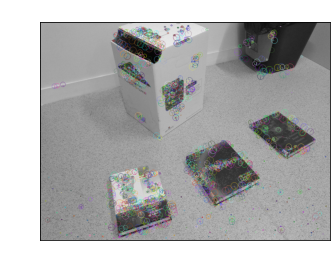

Nb de paires sélectionnées : 92


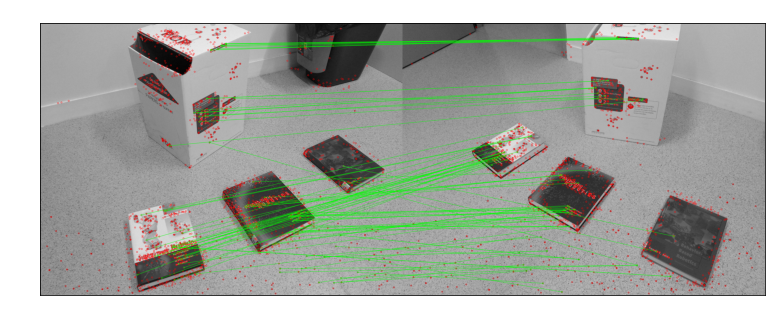

Nb inliers RANSAC : 34


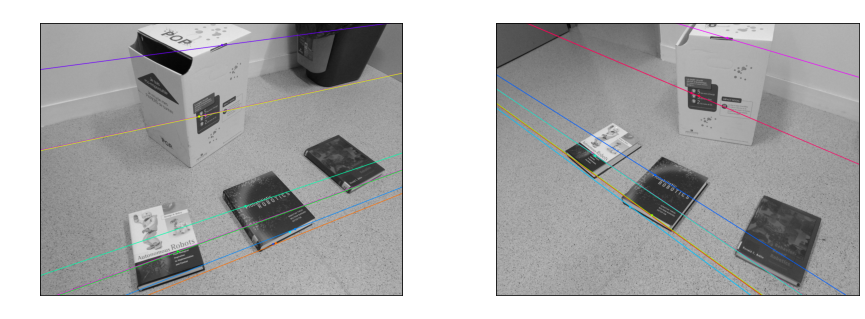


----------------------------------------------------------------------------------------------------

Images : Corridor/bt.001.pgm et Corridor/bt.002.pgm
Nb de points KAZE : 607 (gauche) 586 (droite)


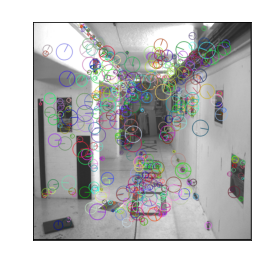

Nb de paires sélectionnées : 365


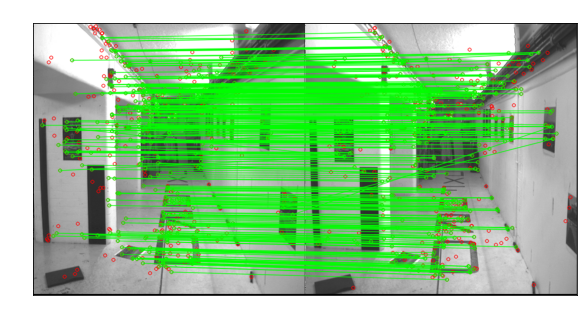

Nb inliers RANSAC : 237


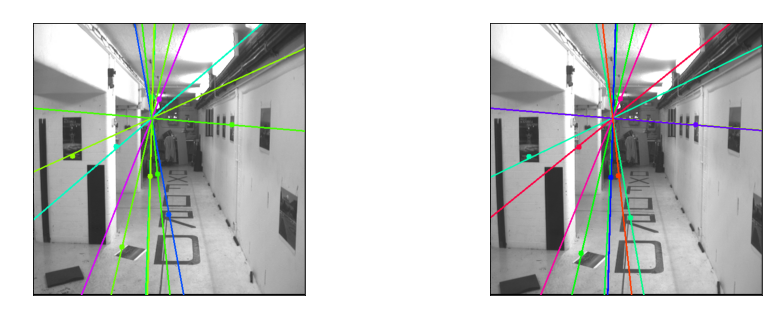


----------------------------------------------------------------------------------------------------

Images : Merton1/002.jpg et Merton1/003.jpg
Nb de points KAZE : 3318 (gauche) 3343 (droite)


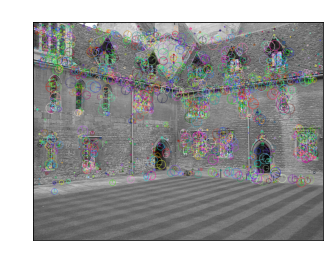

Nb de paires sélectionnées : 521


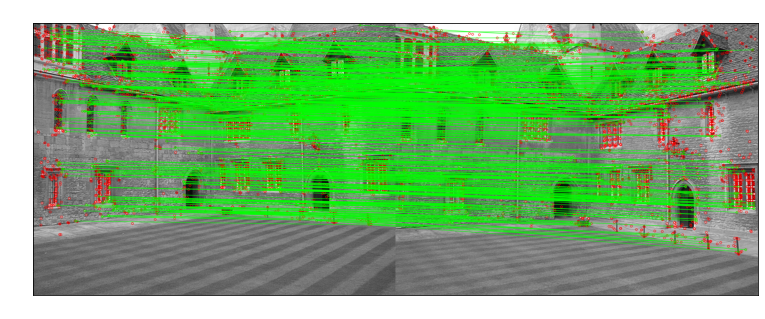

Nb inliers RANSAC : 240


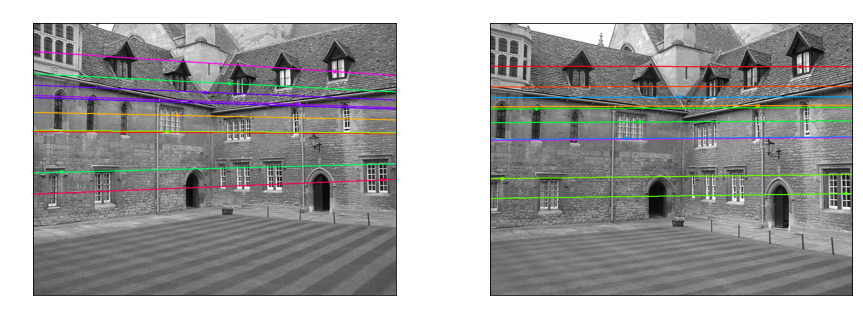


----------------------------------------------------------------------------------------------------

Images : MOVI_ToyHouse1/im002_1.png et MOVI_ToyHouse1/im003_1.png
Nb de points KAZE : 754 (gauche) 754 (droite)


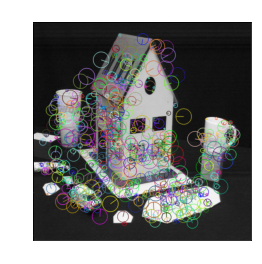

Nb de paires sélectionnées : 487


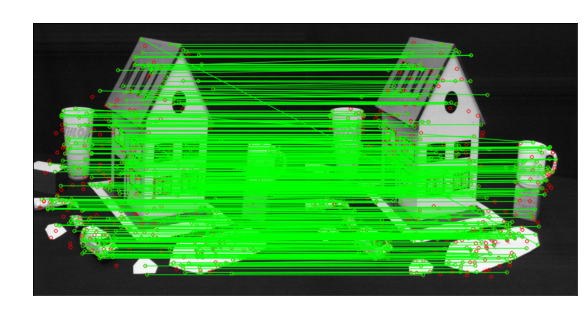

Nb inliers RANSAC : 309


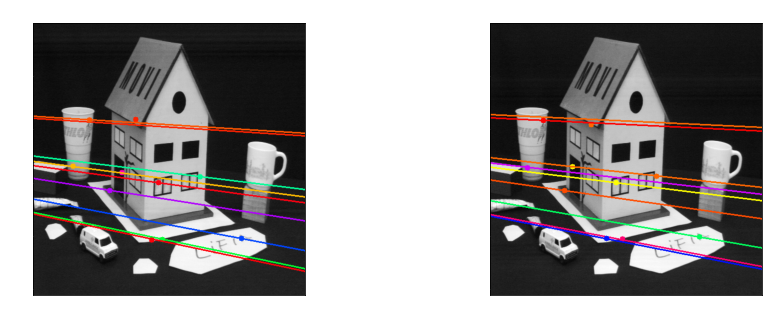


----------------------------------------------------------------------------------------------------



In [6]:
for img1_path, img2_path in images_pair_list:
    print(f'Images : {img1_path} et {img2_path}')
    epipolar_processor.compute_epipolar_lines(
        img1_path=img1_path,
        img2_path=img2_path,
        store=True
    )
    print('\n'+ '-' * 100 + '\n')

## 3. Rectification des images

### Rectifier les images en calculant d’abord les deux homographies rendant les deux faisceaux de droites épipolaires parallèles, grâce à la fonction `OpenCV cv2.stereoRectifyUncalibrated`, puis en appliquant les homographies correspondantes avec la fonction `cv2.warpPerspective`.

In [7]:
def rectify_images(img1, img2, inlierpts1, inlierpts2, F):
    # Calcul des homographies
    retval, H1, H2 = cv2.stereoRectifyUncalibrated(inlierpts1, inlierpts2, F, img1.shape[::-1])
    if not retval:
        raise ValueError("Rectification failed")
    
    img1_rect = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    img2_rect = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    
    return img1_rect, img2_rect

Images : POP01.jpg et POP02.jpg


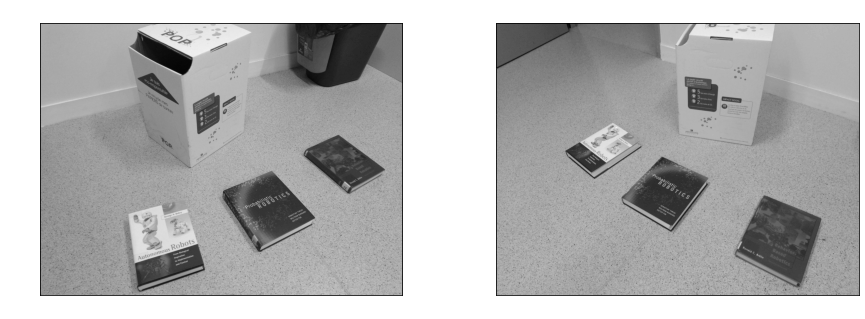

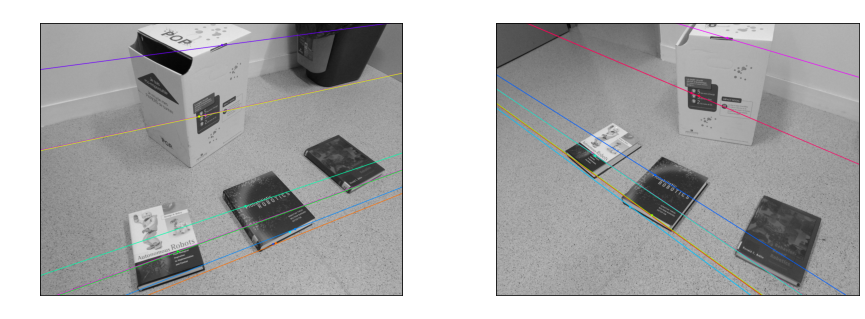

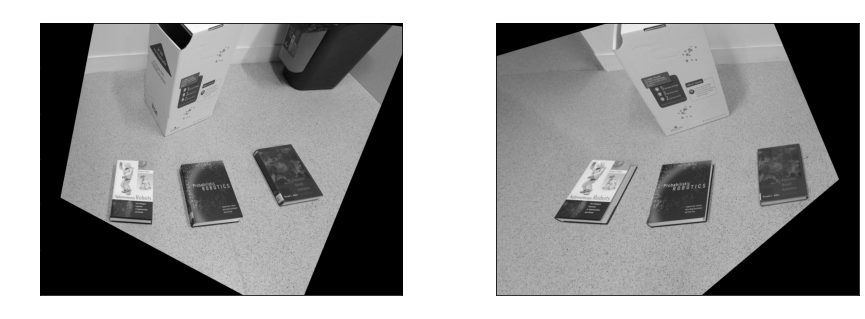

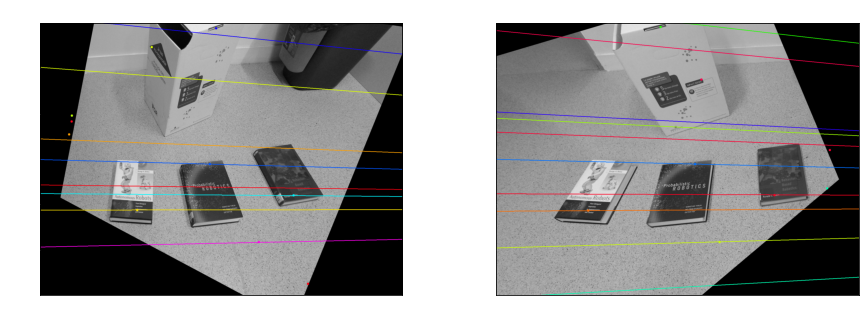


----------------------------------------------------------------------------------------------------

Images : Corridor/bt.001.pgm et Corridor/bt.002.pgm


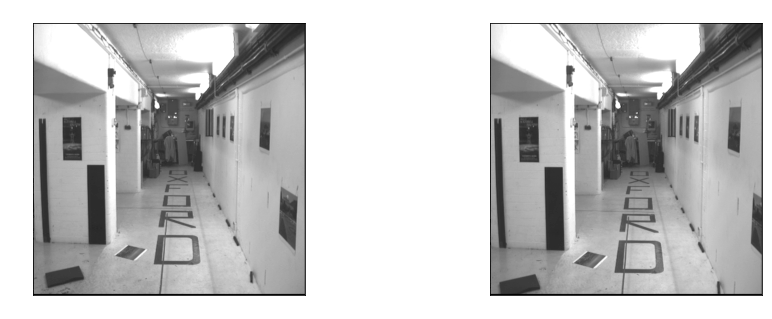

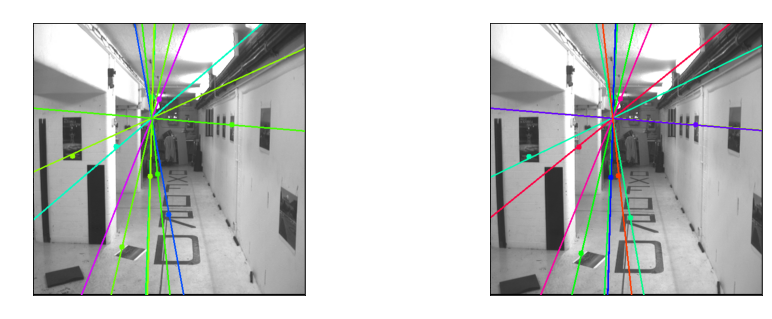

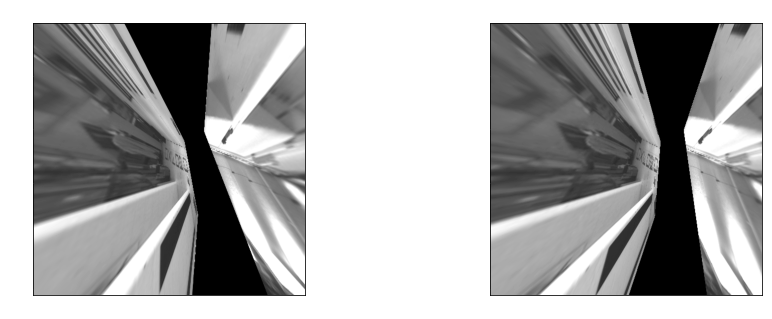

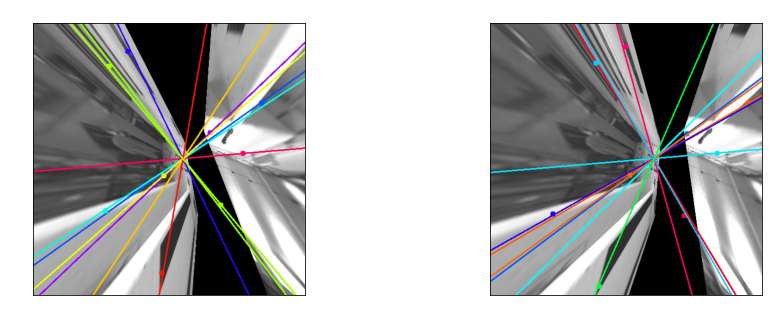


----------------------------------------------------------------------------------------------------

Images : Merton1/002.jpg et Merton1/003.jpg


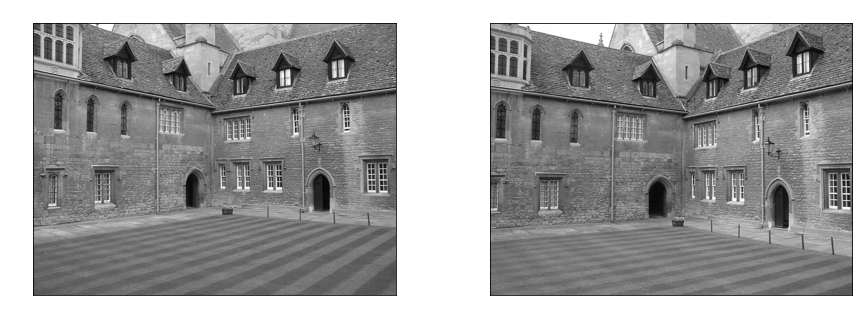

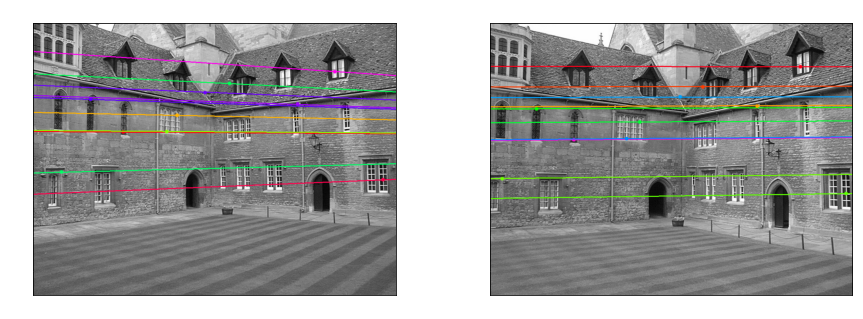

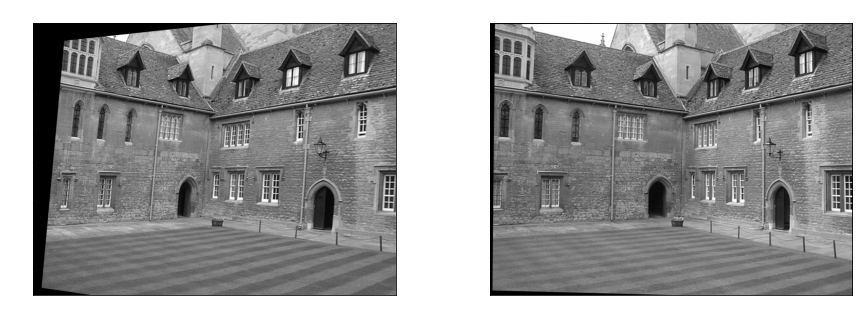

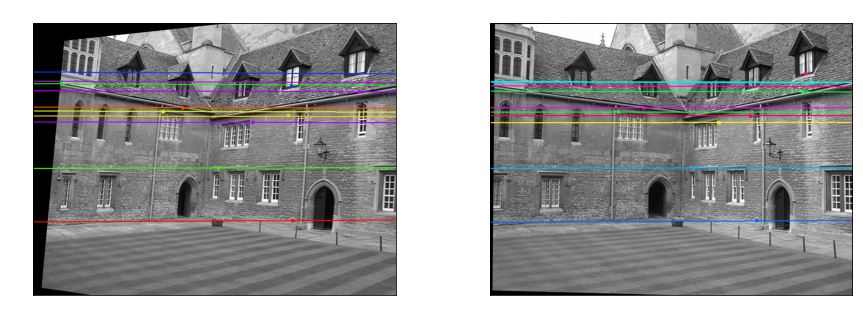


----------------------------------------------------------------------------------------------------

Images : MOVI_ToyHouse1/im002_1.png et MOVI_ToyHouse1/im003_1.png


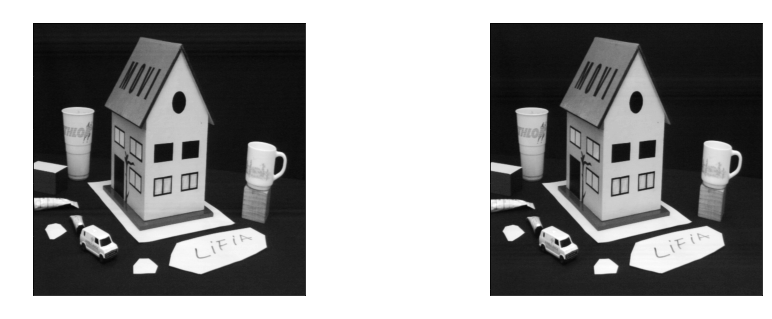

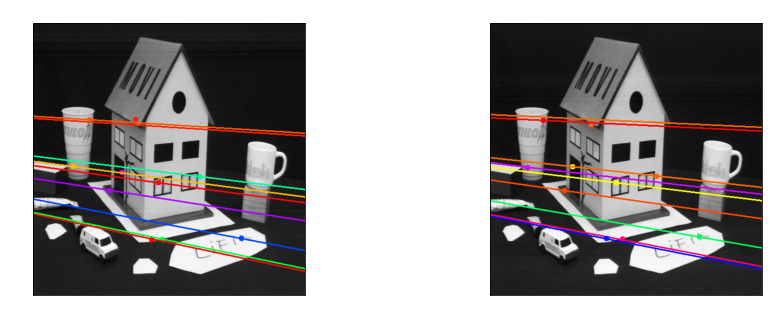

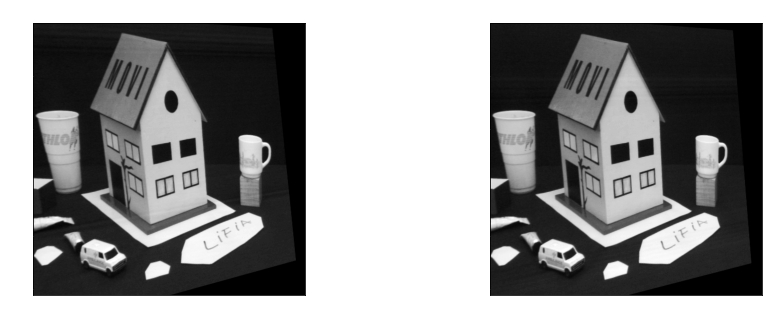

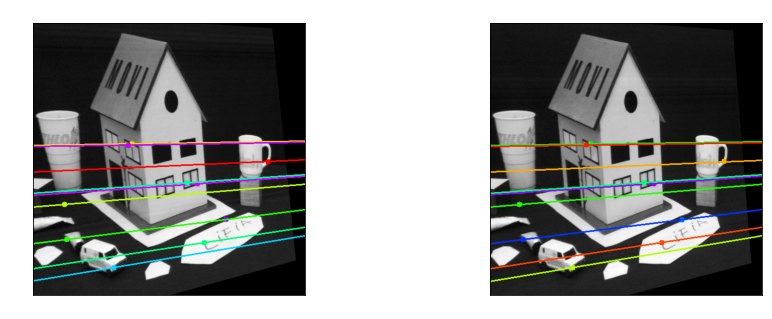


----------------------------------------------------------------------------------------------------



In [8]:
# Rectification des images
epipolar_processor_rect = EpipolarGeometry('./MultiView')
for img1_path, img2_path in images_pair_list:
    print(f'Images : {img1_path} et {img2_path}')
    dict_processed_images = epipolar_processor.results[img1_path]
    
    img1, img2, inlierpts1, inlierpts2, FRansac, imgL, imgR = (
        dict_processed_images['img1'],
        dict_processed_images['img2'],
        dict_processed_images['inlierpts1'],
        dict_processed_images['inlierpts2'],
        dict_processed_images['FRansac'],
        dict_processed_images['imgL'],
        dict_processed_images['imgR']
    )
    
    img1_rect, img2_rect = rectify_images(img1, img2, inlierpts1, inlierpts2, FRansac)
    
    # Affichage des images initiales
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title('Image gauche')
    
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.title('Image droite')
    
    plt.show()
    
    # Affichage des lignes épipolaires des images initiales
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(imgL, cmap='gray')
    plt.title('Lignes épipolaires de l\'image gauche')
    
    plt.subplot(122)
    plt.imshow(imgR, cmap='gray')
    plt.title('Lignes épipolaires de l\'image droite')
    
    plt.show()

    # Affichage des images rectifiées
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(img1_rect, cmap='gray')
    plt.title('Image gauche rectifiée')
    
    plt.subplot(122)
    plt.imshow(img2_rect, cmap='gray')
    plt.title('Image droite rectifiée')
    
    plt.show()
    
    # Calcul et affichage des lignes épipolaires des images rectifiées
    epipolar_processor_rect.compute_epipolar_lines(
        img1_path=img1_path+"_RECT",
        img2_path=img2_path+"_RECT",
        img1=img1_rect,
        img2=img2_rect,
        show_intermediate_results=False,
        store=True
    )
    
    print('\n'+ '-' * 100 + '\n')

### Identifier les difficultés potentielles selon la nature du déplacement et des images.
>  Difficultés potentielles selon la nature du déplacement et des images :
> * __Translation selon l'axe optique (Travelling axial)__ : En cas de déplacement avant ou arrière, la parallaxe est faible ou inexistante, limitant les points utiles pour estimer les différences de profondeur. Par exemple, dans "Corridor1" et "Corridor2", cela entraîne un trop grand nombre de lignes épipolaires et des appariements incorrects, dégradant la qualité du résultat.
> * __Rotation excessive__ : Des rotations trop importantes compliquent la détection des points correspondants. Lorsque les points de vue diffèrent trop, cela limite les inliers disponibles. Par exemple, chaque image peut révéler des détails invisibles dans l'autre, rendant difficile la création d'une correspondance cohérente et homogène.
> * __Textures répétitives__ : Des motifs récurrents peuvent provoquer des appariements incorrects en raison de la similitude des points dans les deux images, rendant la rectification difficile.
> * __Faible contraste__ : Les images avec un faible contraste compliquent la détection des points clés, car il devient difficile de distinguer les caractéristiques uniques nécessaires pour les correspondances.
> * __Occlusions__ : Lorsque certains objets sont masqués dans une image et visibles dans l'autre, cela entraîne des erreurs d'appariement, car les points clés manquent de correspondance.
> * __Distorsions optiques__ : Sans correction des distorsions, la rectification est plus complexe, car ces déformations introduisent des inexactitudes dans la correspondance des points entre les deux images.

## 4. Reconstruction 3d

### Essayer de construire une carte de disparité en utilisant une fonction d’appariement (flot optique) d’OpenCV entre les deux images rectifiées. Que devrait-on observer ? Comment sélectionner les appariements corrects ?
> * En construisant une carte de disparité à partir des images rectifiées, on devrait observer une représentation de la profondeur des objets. Les objets proches de la caméra apparaîtront avec des valeurs de disparité élevées (zones plus claires), tandis que les objets éloignés afficheront des valeurs de disparité faibles (zones plus sombres). Cette carte permet de visualiser la distance relative des objets par rapport à la caméra.
> 
> * Pour sélectionner les appariements corrects, il faut :
>   * __Utiliser des descripteurs robustes__ : Cela permet de détecter efficacement les points clés dans les deux images.
>   * __Appliquer des techniques de filtrage__ : Par exemple, le ratio test de Lowe aide à éliminer les appariements incorrects.
>   * __Utiliser des méthodes de robustesse comme RANSAC__ : Cela permet de rejeter les outliers et de conserver uniquement les appariements conformes au modèle géométrique.
>   * __Minimiser l'erreur d'appariement__ : En utilisant la fonction d’OpenCV pour le flot optique, on peut sélectionner les appariements avec une faible erreur, en se concentrant sur les points pour lesquels le statut (`st`) est égal à 1, ou en fixant un seuil d'erreur basé sur les valeurs d'erreur (`err`).
>
>   Ces étapes permettent de générer une carte de disparité fiable et de s'assurer que seuls les appariements précis sont utilisés pour estimer la profondeur.

In [9]:
def compute_disparity_map(img1_rect, img2_rect):
    # Créer un objet StereoBM pour calculer la carte de disparité
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    disparity = stereo.compute(img1_rect, img2_rect)

    # Normalisation de la carte de disparité
    disparity = cv2.normalize(disparity, disparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity = np.uint8(disparity)

    return disparity

Images : POP01.jpg et POP02.jpg


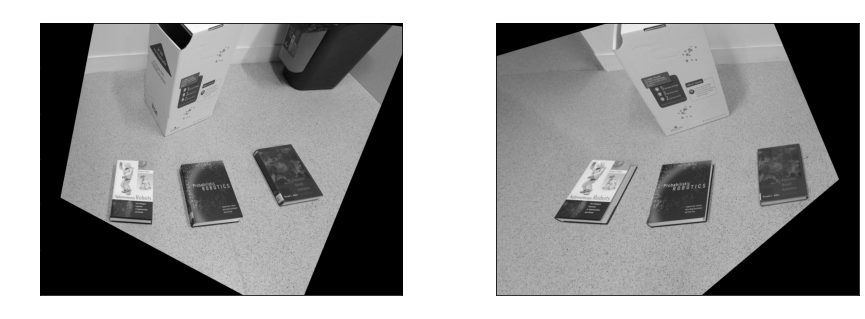

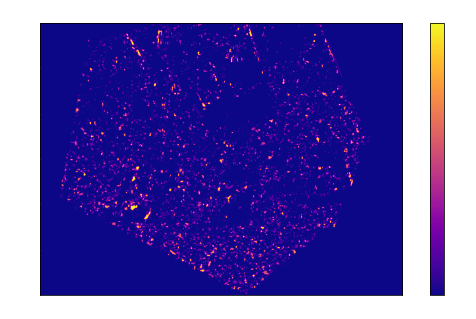


----------------------------------------------------------------------------------------------------

Images : Corridor/bt.001.pgm et Corridor/bt.002.pgm


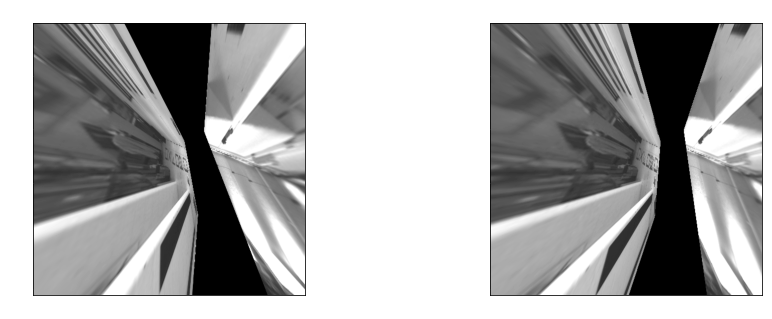

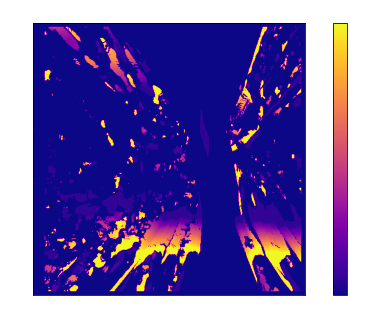


----------------------------------------------------------------------------------------------------

Images : Merton1/002.jpg et Merton1/003.jpg


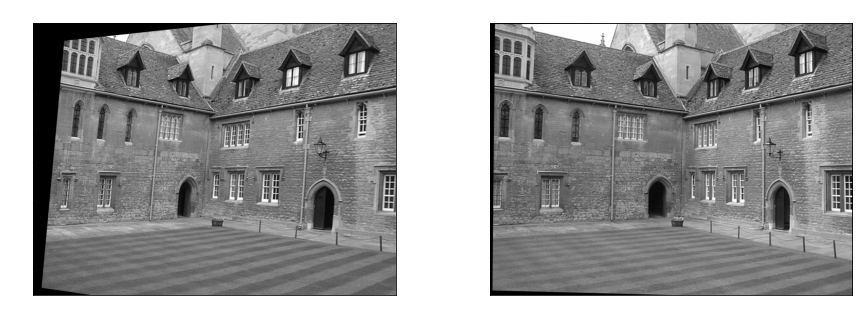

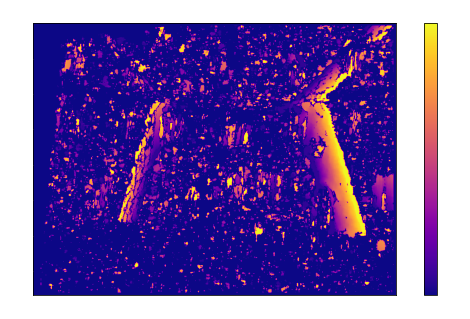


----------------------------------------------------------------------------------------------------

Images : MOVI_ToyHouse1/im002_1.png et MOVI_ToyHouse1/im003_1.png


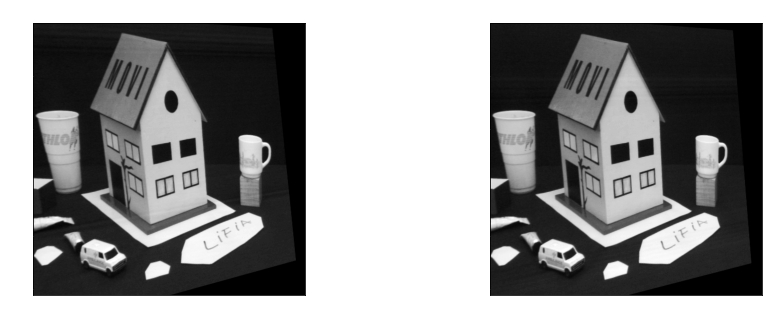

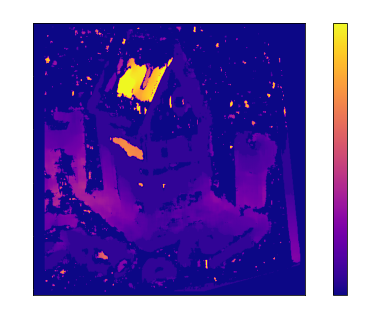


----------------------------------------------------------------------------------------------------



In [10]:
disparities = {}

for img1_path, img2_path in images_pair_list:
    print(f'Images : {img1_path} et {img2_path}')
    dict_processed_images = epipolar_processor_rect.results[img1_path+"_RECT"]

    img1_rect, img2_rect = (
        dict_processed_images['img1'],
        dict_processed_images['img2']
    )
    
    # Affichage des images rectifiées
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(img1_rect, cmap='gray')
    plt.title('Image gauche rectifiée')
    
    plt.subplot(122)
    plt.imshow(img2_rect, cmap='gray')
    plt.title('Image droite rectifiée')
    
    plt.show()
        
    # Calcul de la carte de disparité
    disparities[img1_path] = compute_disparity_map(img1_rect, img2_rect)

    # Affichage de la carte de disparité
    plt.figure(figsize=(10, 5))
    plt.imshow(disparities[img1_path], cmap='plasma')
    plt.title('Carte de disparité')
    plt.colorbar()
    plt.show()
    
    print('\n'+ '-' * 100 + '\n')

### Déduire de cette carte une carte de profondeur relative. Quelles informations faut-il ajouter pour obtenir une métrique absolue ? Comment peut-on obtenir un nuage de points {Mi = (Xi,Yi,Zi)} à partir de la carte de profondeur ?
> * Pour déduire une carte de profondeur relative à partir de la carte de disparité, on peut utiliser la relation entre la disparité et la profondeur. La profondeur (Z) est inversement proportionnelle à la disparité (d) :  $$Z = fB\cdot\frac{1}{d}$$ où (f) est la distance focale de la caméra et (B) est la baseline.
> 
> * Pour obtenir une métrique absolue, on a besoin des paramètres intrinsèques de la caméra, à savoir la distance focale (f) et baseline (B).
> 
> * Pour générer un nuage de points ({M_i = (X_i, Y_i, Z_i)}) à partir de la carte de profondeur, on peut suivre les étapes suivantes :  
>   * Pour chaque pixel ((u, v)) dans la carte de profondeur, calculer les coordonnées 3D correspondantes ((X, Y, Z)).
>   * Utiliser les paramètres intrinsèques de la caméra pour convertir les coordonnées des pixels en coordonnées réels.

In [11]:
def compute_depth_map(disparity, f, B):
    # Eviter les divisions par zéro
    disparity = np.nan_to_num(disparity, nan=0.01, posinf=0.01, neginf=0.01).astype(np.float32)
    disparity[disparity == 0] = 0.01
    depth_map = f * B / disparity
    return depth_map

def compute_point_cloud(depth_map, c_x, c_y, fx, fy):
    # Coordonnées des pixels
    u, v = np.meshgrid(np.arange(depth_map.shape[1]), np.arange(depth_map.shape[0]))
    u = u.astype(np.float32)
    v = v.astype(np.float32)
    
    # Conversion des coordonnées des pixels en coordonnées réelles
    X = (u - c_x) * depth_map / fx
    Y = (v - c_y) * depth_map / fy
    Z = depth_map
    
    points = np.stack((X, Y, Z), axis=-1)
    
    return points

Image : POP01.jpg


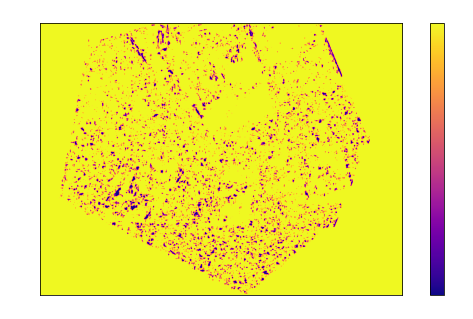


----------------------------------------------------------------------------------------------------

Image : Corridor/bt.001.pgm


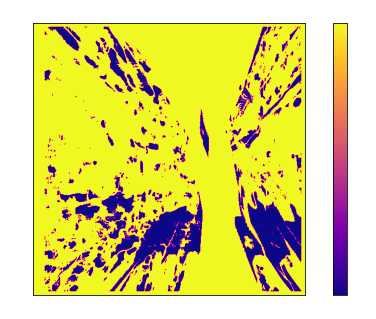


----------------------------------------------------------------------------------------------------

Image : Merton1/002.jpg


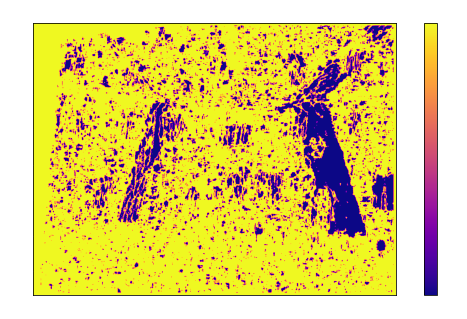


----------------------------------------------------------------------------------------------------

Image : MOVI_ToyHouse1/im002_1.png


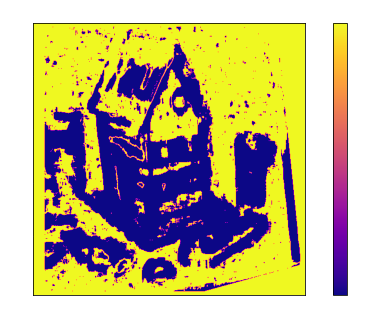


----------------------------------------------------------------------------------------------------



In [12]:
# Paramètres de la caméra intrinsèques
f = 0.01  # Distance focale
B = 1.0  # Baseline

f_x = 0.01  # Distance focale en pixels
f_y = 0.01  # Distance focale en pixels

for img1_path, disparity in disparities.items():
    print(f'Image : {img1_path}')
    depth_map = compute_depth_map(disparity, f, B)
    
    # Affichage de la carte de profondeur
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_map, cmap='plasma')
    plt.title('Carte de profondeur')
    plt.colorbar()
    plt.show()
    
    # Calcul du nuage de points
    cx = 0.5 * disparity.shape[1]
    cy = 0.5 * disparity.shape[0]
    points = compute_point_cloud(depth_map, cx, cy, f_x, f_y)
        
    print('\n'+ '-' * 100 + '\n')